In [152]:
import numpy as np
import pandas as pd
import soundfile as sf
import simpleaudio as sa
import sounddevice as sd
from scipy.io import wavfile
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.titleweight'] = 'bold'

class SignalTB:
    """
        My signal toolbox (SignalTB)!
    """
    
    def __init__(self, x, fs):
        """
        Arguments:
            x: Time Series
            fs: Sample Frequency
        """
        self.fs = fs; # [hz]
        self.x = x    # time domain series
        self.X = None # frequency domain series
        self.sxx = None
        self.gxx = None
        self.gxx_rms_a = None
        self.gxx_linear_a = None
        self.signals = [self.x] #useful container
        
        self.N = self.x.shape[0]   # number of samples
        self.L = self.x.index[-1] - self.x.index[0]   # total time of signal [s]
        self.dt = self.L/self.N  # [s]
        self.df = self.fs/self.N
    
    def get_signals():
        return filter(lambda x: x is not None, [self.X, self.x, self.sxx, self.gxx])
    
    def my_fft(self):
        """
        Description:
            This method calculates the fft of a time domain signal using numpy's fft function and 
        adjusting it appropriately to multiplies it by dt.
        
        Returns:
            Series of frequency domain signal
        """
        freq = np.arange(-np.ceil(self.N/2)+1,
                         np.floor(self.N/2)+1) * self.df
        X = np.fft.fft(a=self.x.values, n=None, axis=-1, norm=None) * self.dt
        X = np.concatenate((X[self.N//2+1:],
                            X[0:self.N//2+1])) # rearrange the frequencies from standard form to sequential. Remember that 1:self.N//2 does not grab that second index value
        X = pd.Series(data=X,
                      index=freq,
                      name='X')
        self.X = X
        self.parseval_thrm(self.x,self.X)  #check Parsevals thrm
        self.signals.append(self.X)
        return X
    
    def my_ifft(self):
        """
        Description:
            This method calculates the ifft of a time domain signal using numpy's ifft function and 
        adjusting it appropriately to multiplies it by dt.
        
        Returns:
            Series of frequency domain signal
        """
        t = np.linspace(start=self.x.index[0], stop=self.x.index[-1], num=self.N, endpoint=True)
        X = self.X.values # these are in sequential, non standard form
        X = np.concatenate((X[int(np.ceil(self.N/2))-1:],
                            X[0:int(np.ceil(self.N/2))-1])) #put the fft values in standard form so ifft can accept it
        x = np.fft.ifft(a=X, n=None, axis=-1, norm=None) / self.dt
        self.parseval_thrm(x,X)  #check Parsevals thrm
        x = pd.Series(data=x,
                      index=t,
                      name='x2')
        self.signals.append(x)
        return x
    
    def parseval_thrm(self, x, X):
        """
        Description:
             Checks to make sure Parseval's Theorem holds between a time domain and FFT holds true

        Arguments:
            x: time domain signal
            X: frequency domain signal
        """
        td = round((x**2).sum() * self.dt, 1)
        fd = round((np.absolute(X)**2).sum() * self.df, 1)
        assert td == fd , "Parseval Theorem not satisfied: {} != {}".format(td,fd)
        
    def sd(self):
        """
        Descrition:
            Spectral Density
        """
        sxx = np.abs(self.X)**2 / self.L; sxx.name = 'S_xx'; #display('sxx',sxx)
        # mean squared check
        X_ms = round(1/self.L * np.sum(np.abs(self.X)**2)*self.df,1)
        sxx_ms = round(np.sum(sxx)*self.df,1)
        assert X_ms == sxx_ms, 'Mean Squared Value Error: {} != {}'.format(X_ms,sxx_ms)
        self.sxx = sxx
        self.signals.append(self.sxx)
        
        #gxx
        freq = np.arange(0, np.floor(self.N/2)+1) * self.df; #display('freq',freq)
        i_zero = int(np.ceil(self.N/2)-1); #display('i_zero',i_zero)

        X = self.sxx.values[i_zero:] * 2 #grab from the center value all the way to the end and double it
        X[0] = X[0]/2
        if self.N%2 == 0: X[-1] = X[-1]/2 #even
        gxx = pd.Series(data=X,
                  index=freq,
                  name='G_xx')

        # mean squared check
        gxx_ms = round(np.sum(gxx) * self.df,1)
        assert sxx_ms == gxx_ms, 'Mean Squared Value Error: {} != {}'.format(sxx_ms,gxx_ms)
        self.gxx = gxx # uts of db
        self.signals.append(self.gxx)
        return self.sxx, self.gxx
    
    def rms_a(self, n_intervals = 16):
        """
            RMS Averaging for Gxx
        """
        frames=[]
        for i in range(1,n_intervals+1):
            x = self.x.iloc[int((i-1)*self.N/n_intervals):int(i*self.N/n_intervals)]
            m = SignalTB(x=x, fs=self.fs)
            m.my_fft(); #calc fft
            m.sd() #calculate sxx and gxx
            frames.append(m.gxx) #save each gxx for averaging
        assert len(frames) == n_intervals, 'Could not perfectly cut the number of samples by the n_interval: {}'.format(n_intervals)
        gxx_rms_a = pd.concat(frames,axis='columns').mean(axis='columns') # calculates the mean of at each row (frequency)
        gxx_rms_a.name = 'G_xx_rms_a'
        self.gxx_rms_a = gxx_rms_a
        self.signals.append(gxx_rms_a)
        return gxx_rms_a
    
    def linear_a(self, n_intervals = 16):
        """
            Linear Averaging for X, then calculation of Gxx
        """
        frames=[]
        for i in range(1,n_intervals+1):
            x = self.x.iloc[int((i-1)*self.N/n_intervals):int(i*self.N/n_intervals)]
            m = SignalTB(x=x, fs=self.fs)
            m.my_fft(); #calc fft
            frames.append(m.X) #save the fft
        assert len(frames) == n_intervals, 'Could not perfectly cut the number of samples by the n_interval: {}'.format(n_intervals)
        X_a = pd.concat(frames,axis='columns').mean(axis='columns') #average all the X's at each frequency

        #generate a temporary object so that you can perform computations
        m = SignalTB(x=self.x.iloc[int((i-1)*self.N/n_intervals):int(i*self.N/n_intervals)], fs=self.fs) # the time signal passed in doesn't mean anything, its just necessary to instatiate object
        m.X = X_a #set the new averaged X_a as the frequency domain signal in the temporary object
        m.sd()
        m.gxx.name = 'G_xx_linear_a'
        self.gxx_linear_a = m.gxx
        self.signals.append(m.gxx)
        return m.gxx

    def time_a(self, n_intervals = 16):
        """
            Time Averaging for x, then calculation of Gxx
        """
        frames=[]
        for i in range(1,n_intervals+1):
            x = self.x.iloc[int((i-1)*self.N/n_intervals):int(i*self.N/n_intervals)]
            x = pd.Series(data=x.values,
                          index=self.x.index[0:int(self.N/n_intervals)]) # make sure that all the objects have the same time index. This is important for taking the average and when we instatiate a new object.
            frames.append(x) #save the fft
        assert len(frames) == n_intervals, 'Could not perfectly cut the number of samples by the n_interval: {}'.format(n_intervals)
        x_a = pd.concat(frames,axis='columns').mean(axis='columns'); #display(x_a);
        
        m = SignalTB(x=x_a, fs=self.fs) #generate a temporary object
        m.my_fft()
        m.sd()
        m.gxx.name = 'G_xx_time_a'
        self.gxx_time_a = m.gxx
        self.signals.append(m.gxx)
        return m.gxx

    def spectrogram(self, n_intervals = 16):
        """
            Spectrogram!
        """
        frames=[]
        for i in range(1,n_intervals+1):
            x = self.x.iloc[int((i-1)*self.N/n_intervals):int(i*self.N/n_intervals)]
            m = SignalTB(x=x, fs=self.fs)
            m.my_fft();
            m.sd()
            m.gxx.name = round(self.x.index[(int((i-1)*self.N/n_intervals) + int(i*self.N/n_intervals))/2],1)  # name the slice at the middle
            frames.append(m.gxx)
        assert len(frames) == n_intervals, 'Could not perfectly cut the number of samples by the n_interval: {}'.format(n_intervals)
        gxx_df = pd.concat(frames,axis='columns').sort_index(ascending=False)
        gxx_df.name = 'Gxx_spectro'
        self.gxx_df = gxx_df
        self.signals.append(self.gxx_df)
        return gxx_df
    
    def plot_signals(self, xrange=None):
        """
        Description:
            Plots all of the signals in the self.signals container
            
        Returns:
            Nothing
        """

        for i, sig in enumerate(self.signals):
            if type(sig) != pd.DataFrame:
                if sig.dtype == complex: sig = np.absolute(sig) # ALWAYS the magnitude of this in case its a complex number
            fig = plt.figure(figsize=(10,5))
            plt.title(sig.name)
            if sig.name in ['x','x2','time domain signal']:
                plt.ylabel('x(t)'); plt.xlabel('t [s]')
            elif sig.name in ['X','S_xx','G_xx','G_xx_rms_a','G_xx_linear_a','G_xx_time_a']:
                sig = 10*np.log10(sig); plt.ylabel('X(f)'); plt.xlabel('f [Hz]'); plt.ylim([-75,0])
            elif sig.name in ['Gxx_spectro']:
                sns.heatmap(sig, cmap="jet"); plt.ylabel('f [Hz]'); plt.xlabel('t [s]')
                continue
            if xrange != None:
                sig[xrange[0]:xrange[1]].plot();
            else:
                sig.plot();
            plt.grid()

    #Useful functions to generate signals
    @staticmethod
    def sin(A,f,L,N):
        """
        Arguments:
            A: Amplitude
            f: Frequency of signal [hz]
            L: Total length of time [s]
            N: Number of points
            
        Returns:
            Series
        """
        t = np.linspace(start=0, stop=L, num=N, endpoint=True, dtype=float)
        return pd.Series(data=A*np.sin(2*np.pi*f*t),
                         index=t,
                         name='x')

    @staticmethod
    def randn_sig(L,N):
        """
        Arguments:
            L : Total length of time [s]
            N : Number of points
            
        Returns:
            Series
        """
        return pd.Series(data=np.random.randn(N,),
                         index=np.linspace(start=0, stop=L, num=N, endpoint=True),
                         name='x')

# HW 2

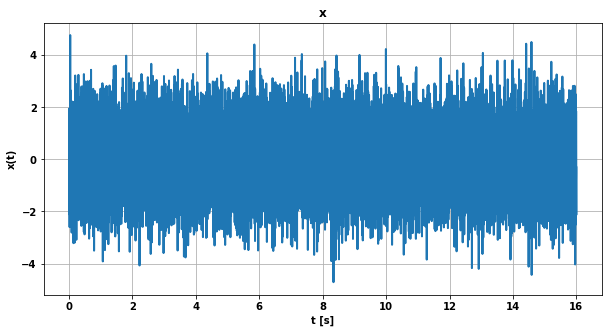

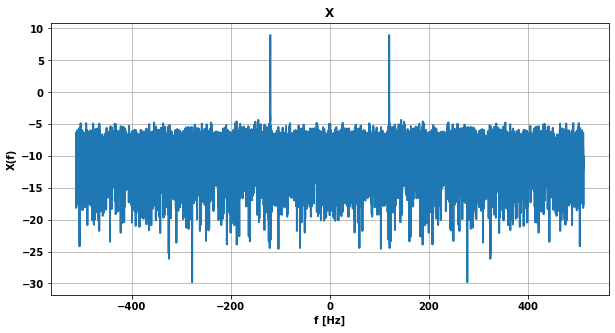

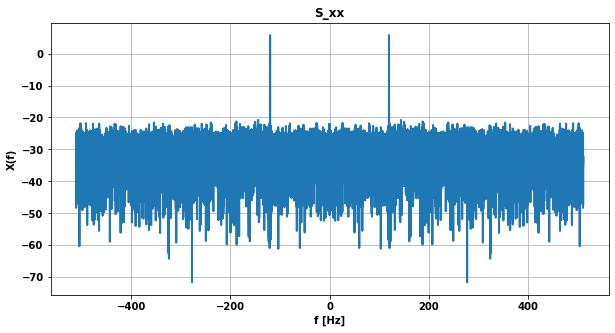

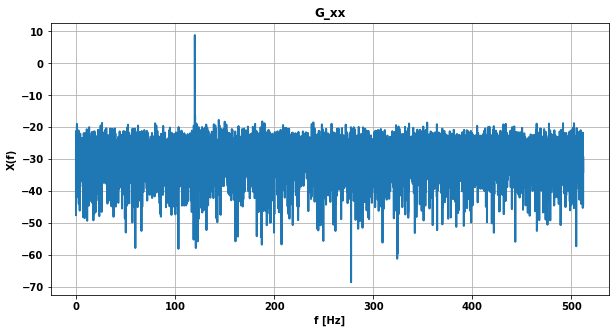

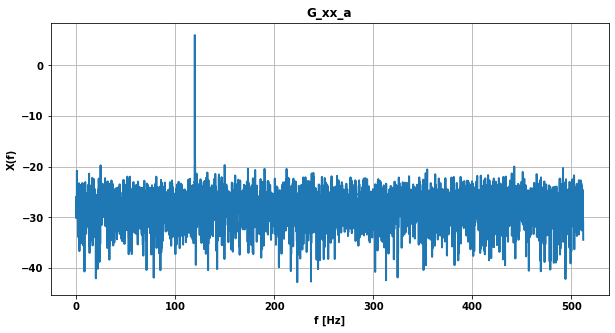

In [44]:
#1.3.1
L = 16 # [s]
fs = 1024 #[hz]
N = int(L/(1/fs));  # generate the number of points based on the sampling frequency which is higher than the actual signal frequency
f_sin = 120;

x = SignalTB.sin(A = 1, f = f_sin, N = N, L = L) + SignalTB.randn_sig(L=L,N=N)

s = SignalTB(x=x, fs=fs)
s.my_fft();
s.sd()
s.rms_a_gxx(n_intervals = 2)
#s.spectrogram(n_intervals = 2);
s.plot_signals();

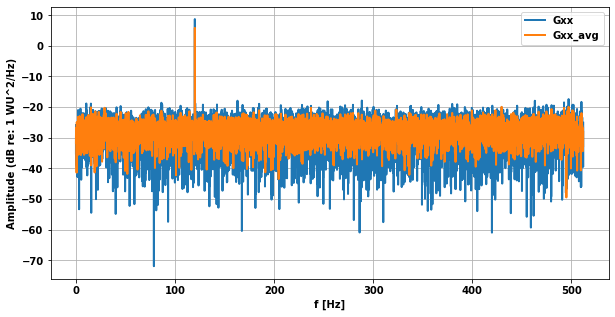

In [41]:
fig = plt.figure(figsize=(10,5))
for myplot in [s.gxx,s.gxx_a]:
    plt.plot(10*np.log10(np.abs(myplot)));
plt.ylabel('Amplitude (dB re: 1 WU^2/Hz)'); plt.xlabel('f [Hz]');
plt.legend(['Gxx','Gxx_avg'])
plt.grid()
fig.savefig('./plots/gxx_a.png', dpi=300, bbox_inches='tight');

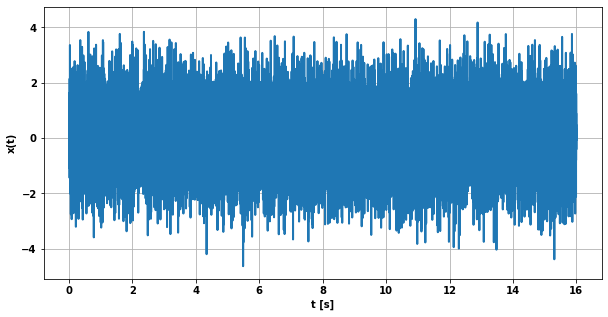

In [43]:
fig = plt.figure(figsize=(10,5))
for myplot in [s.x]:
    plt.plot(myplot);
plt.ylabel('x(t)'); plt.xlabel('t [s]')
plt.grid()
fig.savefig('./plots/time_hw2.png', dpi=300, bbox_inches='tight');